# Análisis de Sentimientos con Arquitectura Transformer
**Proyecto Final - Deep Learning**

**Autor:** Éric Dominguez Morales  
**Fecha:** Agosto 2025

---

## Resumen Ejecutivo

Este proyecto implementa un modelo de análisis de sentimientos utilizando una arquitectura Transformer personalizada para la clasificación binaria de reseñas de películas. El objetivo principal es explorar el funcionamiento interno de los Transformers en el contexto de NLP moderno, desarrollando un flujo de trabajo completo desde la carga de datos hasta el despliegue del modelo.

## Objetivos del Proyecto

### Objetivo Principal
Implementar y entrenar un modelo Transformer custom para clasificación binaria de sentimientos (positivo/negativo) en reseñas de películas del dataset IMDB.

### Objetivos Específicos
- Comprender en profundidad el funcionamiento de la arquitectura Transformer
- Desarrollar un pipeline completo de NLP desde datos brutos hasta modelo desplegado
- Implementar evaluación robusta con intervalos de confianza bootstrap

## Dataset y Metodología

### Dataset IMDB Movie Reviews
- **Tamaño:** 50,000 reseñas balanceadas (25k positivas, 25k negativas)
- **Características:** Texto en inglés con etiquetas HTML y contenido variado
- **División:** 80% entrenamiento, 10% validación, 10% test (estratificada)

### Arquitectura del Modelo
- **Base:** Transformer con 2 capas de atención multi-cabeza
- **Embedding:** Posicional + token embeddings (dim=128)
- **Salida:** Clasificación binaria con activación sigmoid
- **Optimización:** AdamW con weight decay y learning rate scheduling

## 1. Configuración del Entorno y Dependencias

### Bibliotecas Utilizadas

Este proyecto utiliza un stack tecnológico moderno para Deep Learning y NLP:

- **TensorFlow/Keras:** Framework principal para el desarrollo del modelo Transformer
- **TensorFlow Text:** Preprocesamiento avanzado de texto y normalización Unicode
- **Hugging Face Datasets:** Carga eficiente del dataset IMDB
- **Scikit-learn:** Métricas de evaluación y validación
- **Pandas/NumPy:** Manipulación de datos y cálculos numéricos
- **Matplotlib/Seaborn:** Visualización de resultados y análisis exploratorio

### Configuración del Proyecto

El proyecto utiliza un patrón de configuración centralizada mediante dataclasses, lo que permite:
- Gestión organizada de hiperparámetros
- Reproducibilidad mediante semillas fijas
- Fácil experimentación y modificación de parámetros
- Separación clara entre configuración de datos, preprocesado, modelo, entrenamiento, evaluación y despliegue

In [ ]:
import re
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Callable, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex
import seaborn as sns
import tensorflow as tf
import tensorflow_text as text
from datasets import DatasetDict, load_dataset
from sklearn.metrics import accuracy_score, brier_score_loss, f1_score, roc_auc_score
from tensorflow import keras

PROJECT_ROOT = Path().resolve().parent
print("Raíz del proyecto:", PROJECT_ROOT)


@dataclass(frozen=True)
class DataConfig:
    dataset_name: str = "imdb"
    text_feature: str = "text"
    target: str = "label"
    validation_split: float = 0.1
    shuffle_buffer_size: int = 10_000
    label_mapping: Dict[int, str] = field(
        default_factory=lambda: {0: "negativo", 1: "positivo"}
    )


@dataclass(frozen=True)
class PreprocessConfig:
    vocab_size: int = 50_000
    seq_len: int = 256
    html_tags: str = r"<[^>]+>"
    emoji_blocks: str = r"[\x{2600}-\x{27BF}\x{1F000}-\x{1FAFF}]"
    emoji_joiners: str = r"[\x{200D}\x{FE0F}\x{20E3}]"
    multispace: str = r"\s+"

    @staticmethod
    def get_standardize_fn() -> Callable[[tf.Tensor], tf.Tensor]:
        """
        Creates text normalization function for TextVectorization.

        Removes HTML tags, emojis and normalizes whitespace.
        """

        def std_fn(x: tf.Tensor) -> tf.Tensor:
            x = text.normalize_utf8(x, "NFKC")
            x = tf.strings.regex_replace(x, PreprocessConfig.html_tags, " ")
            x = tf.strings.regex_replace(x, PreprocessConfig.emoji_blocks, " ")
            x = tf.strings.regex_replace(x, PreprocessConfig.emoji_joiners, " ")
            x = tf.strings.regex_replace(x, PreprocessConfig.multispace, " ")
            return x

        return std_fn


@dataclass(frozen=True)
class ModelConfig:
    embed_dim: int = 128
    num_heads: int = 4
    ff_dim: int = 256
    num_layers: int = 2
    dropout: float = 0.2
    dense_units_factor: int = 4
    loss_function: str = "binary_crossentropy"
    metrics: List[Union[str, keras.metrics.Metric]] = field(
        default_factory=lambda: ["accuracy", keras.metrics.AUC(name="auc_roc")]
    )


@dataclass(frozen=True)
class TrainingConfig:
    batch_size: int = 32
    epochs: int = 3
    learning_rate: float = 3e-4
    weight_decay: float = 1e-4


@dataclass(frozen=True)
class EvaluationConfig:
    bootstrap_samples: int = 2000
    ci_alpha: float = 0.05
    threshold: float = 0.5
    stratified_sampling: bool = True

    @staticmethod
    def prediction_confidence(prob: float, thresh: float = threshold) -> float:
        """
        Calculates the confidence of a binary prediction.

        Confidence measures how "far" the probability is from the decision threshold.
        Values close to the threshold have low confidence, extreme values (0.0, 1.0) have high confidence.
        """
        f1: float = prob / thresh
        f2: float = (1 - prob) / (1 - thresh)
        return 1 - 0.5 * np.minimum(f1, f2)


@dataclass(frozen=True)
class DeploymentConfig:
    models_dir: str = "models"
    serve_model_name: str = "sentiment_analysis_serve_model"
    call_endpoint: str = "serve"


@dataclass(frozen=True)
class Config:
    data: DataConfig = DataConfig()
    preprocess: PreprocessConfig = PreprocessConfig()
    model: ModelConfig = ModelConfig()
    training: TrainingConfig = TrainingConfig()
    evaluation: EvaluationConfig = EvaluationConfig()
    deployment: DeploymentConfig = DeploymentConfig()
    seed: int = 42


CONFIG = Config()

np.random.seed(CONFIG.seed)
tf.random.set_seed(CONFIG.seed)
tf.keras.utils.set_random_seed(CONFIG.seed)

2025-08-02 05:37:15.126296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-02 05:37:15.127548: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 05:37:15.130537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-02 05:37:15.139742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754105835.154525     668 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754105835.15

Raíz del proyecto: /home/domo/projects/github/My_TokioSchool/deep_learning/m5_copy


E0000 00:00:1754105836.956021     668 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754105836.962097     668 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## 2. Carga y Preparación de Datos

### Dataset IMDB

El dataset IMDB Movie Reviews es un benchmark estándar en análisis de sentimientos que contiene:
- 50,000 reseñas de películas en inglés
- Etiquetas binarias balanceadas (positivo/negativo)
- Texto crudo con etiquetas HTML y caracteres especiales
- División preestablecida train/test

La elección de este dataset se debe a:
1. **Estándar de la industria:** Permite comparación con trabajos previos
2. **Tamaño adecuado:** Suficiente para entrenar Transformers sin requerir recursos masivos
3. **Balanceado:** Evita problemas de desbalance de clases
4. **Texto realista:** Contiene ruido real (HTML, emojis) que requiere preprocesamiento

In [ ]:
ds: DatasetDict = load_dataset(CONFIG.data.dataset_name)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


### División Estratificada de Datos

Se implementa una división estratificada para garantizar representación equilibrada en todos los conjuntos:

- **Entrenamiento (90%):** Para aprendizaje de parámetros del modelo
- **Validación (10%):** Para early stopping  
- **Test (original):** Para evaluación final no sesgada

**Beneficios de la estratificación:**
- Mantiene proporción 50/50 en todos los splits
- Reduce varianza en las métricas de evaluación
- Asegura representatividad estadística

In [ ]:
splits: DatasetDict = ds["train"].train_test_split(
    test_size=CONFIG.data.validation_split,
    shuffle=True,
    seed=CONFIG.seed,
    stratify_by_column=CONFIG.data.target,
)

ds = DatasetDict(
    {
        "train": splits["train"],
        "validation": splits["test"],
        "test": ds["test"],
    }
)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})


### Conversión a TensorFlow Dataset

Se convierten los datos a formato `tf.data.Dataset` para optimizar el pipeline de entrenamiento:

**Ventajas de tf.data:**
- **Eficiencia:** Pipeline optimizado con prefetch y batching automático
- **Memoria:** Carga lazy sin cargar todo el dataset en RAM
- **Paralelización:** Preprocesamiento en paralelo durante entrenamiento
- **Integración:** Compatibilidad nativa con Keras

**Configuración de batching:**
- Batch size: 32 (balance entre memoria y estabilidad de gradientes)
- Shuffle en entrenamiento para evitar patrones de orden
- Sin shuffle en validación/test para reproducibilidad

In [ ]:
train_tf: tf.data.Dataset = ds["train"].to_tf_dataset(
    columns=CONFIG.data.text_feature,
    label_cols=CONFIG.data.target,
    shuffle=True,
    batch_size=CONFIG.training.batch_size,
)
val_tf: tf.data.Dataset = ds["validation"].to_tf_dataset(
    columns=CONFIG.data.text_feature,
    label_cols=CONFIG.data.target,
    shuffle=False,
    batch_size=CONFIG.training.batch_size,
)
test_tf: tf.data.Dataset = ds["test"].to_tf_dataset(
    columns=CONFIG.data.text_feature,
    label_cols=CONFIG.data.target,
    shuffle=False,
    batch_size=CONFIG.training.batch_size,
)

train_df: pd.DataFrame = ds["train"].to_pandas()
val_df: pd.DataFrame = ds["validation"].to_pandas()
test_df: pd.DataFrame = ds["test"].to_pandas()

## 3. Análisis Exploratorio de Datos

### Exploración Inicial del Dataset

El análisis exploratorio es fundamental para comprender las características del texto y diseñar estrategias de preprocesamiento efectivas.

In [ ]:
print("Dimensiones:", train_df.shape)
train_df.head()

Dimensiones: (22500, 2)


,text,label
0,Every generation fully believes it is living i...,0
1,This movie has one of the cheesiest plots I ha...,1
2,Because 'cruel' would be the only word in exis...,0
3,Even though many people here praises this movi...,0
4,"Meatball Machine is an amazing splatter film, ...",1


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    22500 non-null  object
 1   label   22500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 351.7+ KB


### Evaluación de Calidad de Datos

Se realiza un análisis exhaustivo de la calidad del texto para identificar problemas comunes en datos reales:

**Problemas a tener en cuenta:**
- **Valores nulos:** Registros sin contenido que pueden causar errores en el pipeline
- **Duplicados:** Reseñas idénticas que pueden causar overfitting
- **Etiquetas HTML:** Marcado web que no aporta información semántica
- **Emojis y Unicode:** Caracteres especiales que requieren normalización

**Impacto en el modelo:**
- Los duplicados pueden inflar artificialmente las métricas
- El HTML introduce ruido que puede confundir al modelo
- La normalización Unicode mejora la consistencia del vocabulario

In [ ]:
print("Shape del dataset:", train_df.shape)
print("Valores nulos:", train_df.isnull().sum().sum())
print("Textos vacíos:", (train_df[CONFIG.data.text_feature].str.strip() == "").sum())
print("Duplicados:", train_df.duplicated().sum())
print(
    "Etiquetas HTML:",
    train_df[CONFIG.data.text_feature]
    .str.contains(CONFIG.preprocess.html_tags, na=False)
    .sum(),
)
EMOJI_RE: regex.Pattern[str] = regex.compile(r"\p{Extended_Pictographic}")
print(
    "Emojis:",
    train_df[CONFIG.data.text_feature]
    .fillna("")
    .map(lambda s, pat=EMOJI_RE: sum(1 for _ in pat.finditer(s)))
    .sum(),
)
NFKC_RE: regex.Pattern[str] = regex.compile(
    r"\p{NFKC_Quick_Check=No}|\p{NFKC_Quick_Check=Maybe}"
)
print(
    "Unicode (NFKC):",
    train_df[CONFIG.data.text_feature]
    .fillna("")
    .map(lambda s, pat=NFKC_RE: sum(1 for _ in pat.finditer(s)))
    .sum(),
)

Shape del dataset: (22500, 2)
Valores nulos: 0
Textos vacíos: 0
Duplicados: 73
Etiquetas HTML: 13230
Emojis: 4
Unicode (NFKC): 274


In [ ]:
print("Shape antes:", train_df.shape)
train_df = train_df.drop_duplicates().reset_index(drop=True)
print("Shape después:", train_df.shape)

Shape antes: (22500, 2)
Shape después: (22427, 2)


### Análisis de Características del Texto

**Distribución de longitudes:**
- Examina la variabilidad en longitud de reseñas
- Ayuda a la elección de secuencia máxima (`seq_len`)
- Percentiles ayudan a minimizar pérdida de información

**Análisis de vocabulario:**
- Examina la diversidad léxica del corpus
- Ayuda a la elección del tamaño del vocabulario (`vocab_size`)
- Analiza la distribución de frecuencias de palabras individuales  

**Distribución de clases:**
- Confirma balanceado perfecto (50/50)
- Simplifica elección de métricas de evaluación
- Elimina necesidad de técnicas de balanceado

In [ ]:
print("Clases únicas:", train_df[CONFIG.data.target].unique())
print(
    "Análisis de longitud de textos:",
    pd.Series.describe(
        train_df[CONFIG.data.text_feature].str.split().str.len(),
        percentiles=[0.5, 0.9, 0.95, 0.99],
    ),
    sep="\n",
)
print(
    "Análisis de palabras únicas:",
    pd.Series.describe(
        train_df[CONFIG.data.text_feature]
        .str.lower()
        .apply(lambda s: re.findall(r"\b\w+\b", s))
        .explode()
        .dropna()
    ),
    sep="\n",
)
print(
    "Distribución de clases:",
    train_df[CONFIG.data.target].value_counts(normalize=True),
    sep="\n",
)

Clases únicas: [0 1]
Análisis de longitud de textos:
count    22427.000000
mean       234.572703
std        174.520982
min         10.000000
50%        175.000000
90%        461.000000
95%        601.000000
99%        917.000000
max       2470.000000
Name: text, dtype: float64
Análisis de palabras únicas:
count     5452043
unique      71856
top           the
freq       303086
Name: text, dtype: object
Distribución de clases:
label
1    0.500736
0    0.499264
Name: proportion, dtype: float64


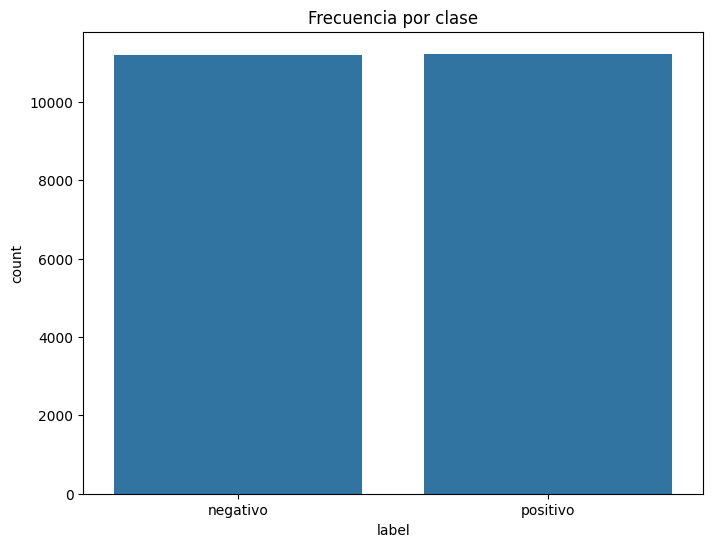

In [ ]:
plt.figure(figsize=(8, 6))
ax: plt.Axes = sns.countplot(x=CONFIG.data.target, data=train_df)

tick_positions: np.ndarray = ax.get_xticks()
tick_labels: List[str] = [
    CONFIG.data.label_mapping.get(int(pos), f"Clase_{int(pos)}")
    for pos in tick_positions
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
plt.title("Frecuencia por clase")
plt.show()

## 4. Arquitectura del Modelo Transformer

### Fundamentos Teóricos

Los **Transformers** representan un paradigma revolucionario en NLP, introducido en "Attention Is All You Need" (Vaswani et al., 2017). Sus ventajas principales son:

**Ventajas sobre RNNs/LSTMs:**
- **Paralelización:** Procesamiento simultáneo de toda la secuencia
- **Dependencias largas:** Atención directa entre cualquier par de tokens
- **Escalabilidad:** Arquitectura que mejora con más datos y cómputo

**Componentes clave implementados:**
1. **Positional Embedding:** Codifica información posicional sin recursión
2. **Multi-Head Attention:** Múltiples "vistas" de las relaciones entre tokens
3. **Feed-Forward Networks:** Transformación no-lineal de las representaciones
4. **Residual Connections + LayerNorm:** Estabilidad y flujo de gradientes

### Decisiones de Diseño

**Justificación de hiperparámetros:**
- **embed_dim=128:** Balance entre capacidad expresiva y eficiencia computacional
- **num_heads=4:** Permite capturar diferentes tipos de relaciones semánticas
- **num_layers=2:** Profundidad suficiente para el problema sin overfitting
- **seq_len=256:** Cubre solo el >50% de reseñas pero con 512 (~90%) aumentaba demasiado el tiempo de entrenamiento

### 4.1 Positional Embedding Layer

**Problema que resuelve:**
Los Transformers, a diferencia de RNNs, procesan secuencias en paralelo y no tienen noción inherente del orden. Los embeddings posicionales resuelven esto inyectando información de posición.

**Implementación:**
- **Token embeddings:** Representación semántica de cada palabra
- **Position embeddings:** Representación de la posición en la secuencia  
- **Combinación aditiva:** Suma simple que preserva ambas informaciones

**Ventajas sobre encoding sinusoidal:**
- Aprendizaje adaptativo a los datos específicos
- Mayor flexibilidad para secuencias de longitud fija
- Optimización end-to-end integrada

In [ ]:
class PositionalEmbedding(keras.layers.Layer):
    """
    Combines token and positional embeddings for sequences.

    Adds the token embedding with its positional embedding.
    """

    def __init__(
        self, max_len: int, vocab_size: int, embed_dim: int, **kwargs: Any
    ) -> None:
        super().__init__(**kwargs)
        self.token_emb: keras.layers.Embedding = keras.layers.Embedding(
            vocab_size, embed_dim
        )
        self.pos_emb: keras.layers.Embedding = keras.layers.Embedding(
            max_len, embed_dim
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        maxlen: tf.Tensor = tf.shape(x)[-1]
        positions: tf.Tensor = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### 4.2 Transformer Block

**Arquitectura del bloque:**
Implementa la estructura canónica: `Attention → Add&Norm → FFN → Add&Norm`

**Multi-Head Attention:**
- **4 cabezas:** Capturan diferentes tipos de relaciones (sintácticas, semánticas)
- **Self-attention:** Cada token atiende a todos los demás en la secuencia
- **Escalabilidad:** Complejidad O(n²) en longitud de secuencia

**Feed-Forward Network:**
- **Expansión:** 128 → 256 → 128 dimensiones
- **Activación GELU:** Más suave que ReLU, mejor para gradientes
- **Bottleneck:** Fuerza compresión de información relevante

**Regularización:**
- **Dropout:** 0.2 para prevenir overfitting
- **Layer Normalization:** Estabiliza entrenamiento y acelera convergencia
- **Residual connections:** Facilitan flujo de gradientes en redes profundas

In [ ]:
class TransformerBlock(keras.layers.Layer):
    """
    Transformer block with multi-head attention and feed-forward.

    Implements: attention -> add&norm -> ffn -> add&norm
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ff_dim: int,
        dropout: float = CONFIG.model.dropout,
        **kwargs: Any
    ) -> None:
        super().__init__(**kwargs)
        self.att: keras.layers.MultiHeadAttention = keras.layers.MultiHeadAttention(
            num_heads, key_dim=embed_dim
        )
        self.ffn: keras.Sequential = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="gelu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.ln1: keras.layers.LayerNormalization = keras.layers.LayerNormalization(
            epsilon=1e-6
        )
        self.ln2: keras.layers.LayerNormalization = keras.layers.LayerNormalization(
            epsilon=1e-6
        )
        self.dropout1: keras.layers.Dropout = keras.layers.Dropout(dropout)
        self.dropout2: keras.layers.Dropout = keras.layers.Dropout(dropout)

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        attn_output: tf.Tensor = self.att(inputs, inputs, attention_mask=None)
        attn_output = self.dropout1(attn_output, training=training)
        out1: tf.Tensor = self.ln1(inputs + attn_output)
        ffn_output: tf.Tensor = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.ln2(out1 + ffn_output)

### 4.3 Construcción del Modelo Completo

**Pipeline de procesamiento:**
```
Texto crudo → TextVectorization → Positional Embedding → 2× TransformerBlock → Classification Head
```

**Cabeza de clasificación:**
- **Global Average Pooling:** Agrega información de toda la secuencia
- **Dense layer:** 64 unidades (256/4) con activación GELU
- **Salida binaria:** 1 neurona con sigmoid para probabilidades [0,1]

**Optimización:**
- **AdamW:** Adam con weight decay regularizado
- **Learning rate:** 3e-4 (estándar para Transformers pequeños)
- **Weight decay:** 1e-4 para regularización L2 implícita

**Métricas de monitoreo:**
- **Accuracy:** Interpretabilidad directa
- **AUC-ROC:** Robustez ante diferentes thresholds

In [ ]:
def build_model(
    text_vectorizer: keras.layers.TextVectorization,
    seq_len: int = CONFIG.preprocess.seq_len,
    embed_dim: int = CONFIG.model.embed_dim,
    num_heads: int = CONFIG.model.num_heads,
    ff_dim: int = CONFIG.model.ff_dim,
    dropout: float = CONFIG.model.dropout,
    lr: float = CONFIG.training.learning_rate,
    wd: float = CONFIG.training.weight_decay,
) -> keras.Model:
    """
    Builds a Transformer model for sentiment analysis.

    Architecture: TextVectorization -> Embedding -> 2x TransformerBlock -> Classification
    """
    inputs: keras.Input = keras.Input(shape=(), dtype=tf.string, name="text")
    x: tf.Tensor = text_vectorizer(inputs)
    x = PositionalEmbedding(seq_len, text_vectorizer.vocabulary_size(), embed_dim)(x)

    for _ in range(CONFIG.model.num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(
        ff_dim // CONFIG.model.dense_units_factor, activation="gelu"
    )(x)
    x = keras.layers.Dropout(dropout)(x)
    outputs: tf.Tensor = keras.layers.Dense(1, activation="sigmoid")(x)

    model: keras.Model = keras.Model(inputs, outputs, name="sentiment_analysis_model")

    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd),
        loss=CONFIG.model.loss_function,
        metrics=CONFIG.model.metrics,
    )

    return model

## 5. Preprocesamiento y Vectorización

### TextVectorization Layer

**Beneficios de la integración nativa:**
- **Pipeline unificado:** Preprocesamiento incluido en el modelo
- **Despliegue simplificado:** No requiere preprocesamiento externo
- **Consistencia:** Misma transformación en entrenamiento e inferencia

**Configuración del vocabulario:**
- **Tamaño:** 50,000 tokens (balance entre cobertura y eficiencia)
- **Longitud de secuencia:** 512 tokens (basado en análisis de percentiles)
- **Normalización:** NFKC Unicode + limpieza de HTML/emojis

### Análisis de Out-of-Vocabulary (OOV)

La métrica OOV indica qué proporción del vocabulario de validación no se encuentra en el vocabulario de entrenamiento. Un OOV bajo sugiere buena cobertura del vocabulario. Lo ideal es un OOV menor al 5%.

In [ ]:
text_vectorizer: keras.layers.TextVectorization = keras.layers.TextVectorization(
    max_tokens=CONFIG.preprocess.vocab_size,
    output_sequence_length=CONFIG.preprocess.seq_len,
    standardize=CONFIG.preprocess.get_standardize_fn(),
    split="whitespace",
    output_mode="int",
)

text_vectorizer.adapt(train_tf.map(lambda x, _: x))

oov_id: int = text_vectorizer.get_vocabulary().index("[UNK]")
oov: tf.Tensor
tot: tf.Tensor
oov, tot = (
    val_tf.map(lambda x, y: text_vectorizer(x))
    .map(
        lambda ids: (
            tf.reduce_sum(tf.cast(ids == oov_id, tf.int64)),
            tf.size(ids, out_type=tf.int64),
        )
    )
    .reduce(
        (tf.constant(0, tf.int64), tf.constant(0, tf.int64)),
        lambda a, b: (a[0] + b[0], a[1] + b[1]),
    )
)
print(f"OOV: {oov.numpy() / tot.numpy():.3%}")

2025-08-02 05:37:28.443601: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


OOV: 4.033%


In [ ]:
model: keras.Model = build_model(text_vectorizer)

model.summary()

Model: "sentiment_analysis_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 256)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, 256, 128)       │     6,432,768 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 256, 128)       │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 256, 128)       │       330,240 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,101,569 (27.09 MB)

 Trainable params: 7,101,569 (27.09 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrenamiento del Modelo

### Estrategia de Entrenamiento

**Configuración de epochs:**
Se utilizan **3 epochs** como balance óptimo entre:
- **Tiempo de cómputo:** Entrenamientos no excesivamente largos
- **Rendimiento:** Suficiente para convergencia sin overfitting
- **Recursos:** Factible en hardware limitado

In [ ]:
history: keras.callbacks.History = model.fit(
    train_tf,
    validation_data=val_tf,
    epochs=CONFIG.training.epochs,
    batch_size=CONFIG.training.batch_size,
    verbose=1,
)

Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 255s 356ms/step - accuracy: 0.7616 - auc_roc: 0.8577 - loss: 0.4632 - val_accuracy: 0.8580 - val_auc_roc: 0.9480 - val_loss: 0.3394
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 253s 359ms/step - accuracy: 0.9350 - auc_roc: 0.9820 - loss: 0.1688 - val_accuracy: 0.8016 - val_auc_roc: 0.9250 - val_loss: 0.7265
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 254s 360ms/step - accuracy: 0.9783 - auc_roc: 0.9971 - loss: 0.0628 - val_accuracy: 0.8840 - val_auc_roc: 0.9222 - val_loss: 0.6143


### Análisis de Curvas de Entrenamiento

**Métricas monitoreadas:**

1. **Loss (Binary Crossentropy):**
   - Convergencia de la función objetivo
   - Gap train/val indica nivel de overfitting

2. **Accuracy:**
   - Métrica interpretable directamente
   - Apropiada para clases balanceadas

3. **AUC-ROC:**
   - Robusta ante diferentes thresholds
   - Métrica principal para early stopping

4. **Brecha de Pérdida (Gap Analysis):**
   - Diferencia val_loss - train_loss
   - Indicador temprano de overfitting
   - Permite ajustar regularización

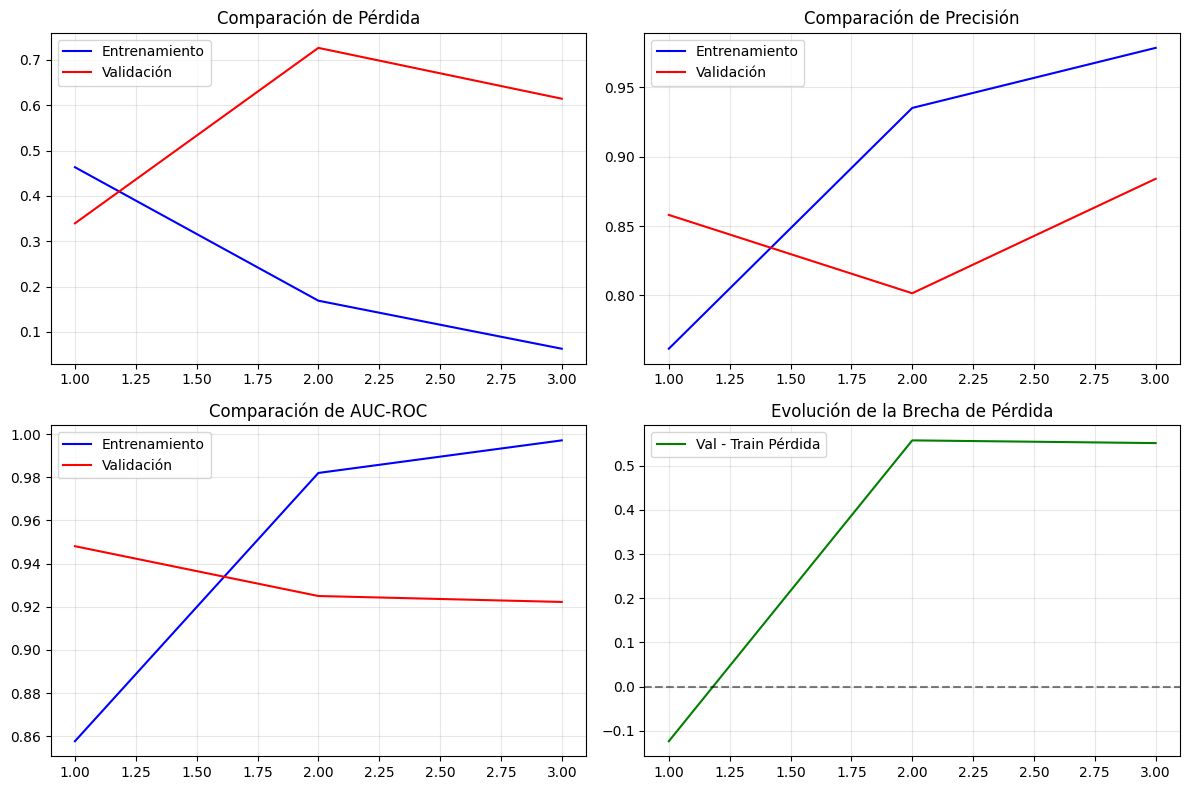

In [ ]:
epochs: range = range(1, len(history.history["loss"]) + 1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(epochs, history.history["loss"], "b-", label="Entrenamiento")
axes[0, 0].plot(epochs, history.history["val_loss"], "r-", label="Validación")
axes[0, 0].set_title("Comparación de Pérdida")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(epochs, history.history["accuracy"], "b-", label="Entrenamiento")
axes[0, 1].plot(epochs, history.history["val_accuracy"], "r-", label="Validación")
axes[0, 1].set_title("Comparación de Precisión")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(epochs, history.history["auc_roc"], "b-", label="Entrenamiento")
axes[1, 0].plot(epochs, history.history["val_auc_roc"], "r-", label="Validación")
axes[1, 0].set_title("Comparación de AUC-ROC")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

loss_gap: List[float] = [
    v - t for t, v in zip(history.history["loss"], history.history["val_loss"])
]
axes[1, 1].plot(epochs, loss_gap, "g-", label="Val - Train Pérdida")
axes[1, 1].axhline(y=0, color="k", linestyle="--", alpha=0.5)
axes[1, 1].set_title("Evolución de la Brecha de Pérdida")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Evaluación y Métricas

### Evaluación en Conjunto de Test

**Proceso de evaluación:**
1. **Predicciones:** Probabilidades continuas [0,1]
2. **Threshold:** 0.5 para clasificación binaria
3. **Métricas múltiples:** Evaluación comprehensiva del rendimiento

**Justificación del threshold fijo:**
- **Clases balanceadas:** 0.5 es óptimo teóricamente
- **Simplicidad:** Facilita interpretación y despliegue
- **Benchmark:** Estándar en literatura para IMDB

In [ ]:
y_pred_proba: np.ndarray = model.predict(test_tf, verbose=1)
y_pred: np.ndarray = (y_pred_proba >= CONFIG.evaluation.threshold).astype(int)
y_true: np.ndarray = test_df[CONFIG.data.target].values

782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 112ms/step


### Evaluación Robusta con Bootstrap

**Intervalos de Confianza Bootstrap:**

**¿Por qué bootstrap?**
- **Incertidumbre:** Una sola métrica no captura variabilidad
- **Confiabilidad:** Intervalos de confianza al 95%
- **Robustez:** No asume distribuciones específicas

**Métricas evaluadas:**

1. **Accuracy:** Proporción de predicciones correctas
2. **F1-Score:** Media armónica de precisión y recall
3. **AUC-ROC:** Área bajo curva ROC (independiente del threshold)
4. **Brier Score:** Calidad de calibración probabilística

**Configuración bootstrap:**
- **Muestras:** 2,000 bootstrap samples
- **Estratificado:** Mantiene proporción de clases
- **Semilla fija:** Reproducibilidad de resultados

In [ ]:
def bootstrap_metrics_ci(
    y_true: np.ndarray,
    y_proba: np.ndarray,
    B: int = CONFIG.evaluation.bootstrap_samples,
    alpha: float = CONFIG.evaluation.ci_alpha,
    stratified: bool = CONFIG.evaluation.stratified_sampling,
    seed: int = CONFIG.seed,
) -> Dict[str, Dict[str, Union[float, Tuple[float, float]]]]:
    """
    Calculates bootstrap confidence intervals for classification metrics.

    Returns accuracy, f1, roc_auc and brier with their 95% confidence intervals.
    """
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba).astype(float)
    assert y_true.shape[0] == y_proba.shape[0]

    n: int = y_true.shape[0]
    rng: np.random.Generator = np.random.default_rng(seed)

    pos_idx: np.ndarray = np.where(y_true == 1)[0]
    neg_idx: np.ndarray = np.where(y_true == 0)[0]
    n_pos, n_neg = len(pos_idx), len(neg_idx)

    metrics: Dict[str, List[float]] = {
        "accuracy": [],
        "f1": [],
        "roc_auc": [],
        "brier": [],
    }

    for _ in range(B):
        if stratified:
            i_pos: np.ndarray = rng.integers(0, n_pos, n_pos)
            i_neg: np.ndarray = rng.integers(0, n_neg, n_neg)
            idx: np.ndarray = np.concatenate([pos_idx[i_pos], neg_idx[i_neg]])
        else:
            idx = rng.integers(0, n, n)

        yt: np.ndarray = y_true[idx]
        pp: np.ndarray = y_proba[idx]
        yp: np.ndarray = (pp >= CONFIG.evaluation.threshold).astype(int)

        if len(np.unique(yt)) < 2:
            continue

        metrics["accuracy"].append(accuracy_score(yt, yp))
        metrics["f1"].append(f1_score(yt, yp))
        metrics["roc_auc"].append(roc_auc_score(yt, pp))
        metrics["brier"].append(brier_score_loss(yt, pp))

    out: Dict[str, Dict[str, Union[float, Tuple[float, float]]]] = {}
    for k, vals in metrics.items():
        vals: np.ndarray = np.array(vals, dtype=float)
        lo, hi = np.percentile(vals, [100 * alpha / 2, 100 * (1 - alpha / 2)])
        out[k] = {"point": float(vals.mean()), "ci": (float(lo), float(hi))}
    return out


res: Dict[str, Dict[str, Union[float, Tuple[float, float]]]] = bootstrap_metrics_ci(
    y_true, y_pred_proba
)
for k, v in res.items():
    print(f"{k:8s}: {v['point']:.4f}  IC95% [{v['ci'][0]:.4f}, {v['ci'][1]:.4f}]")

accuracy: 0.8431  IC95% [0.8386, 0.8474]
f1      : 0.8399  IC95% [0.8352, 0.8445]
roc_auc : 0.9226  IC95% [0.9194, 0.9257]
brier   : 0.1369  IC95% [0.1331, 0.1407]


## 8. Modelo Final y Despliegue

### Entrenamiento en Dataset Completo

**Estrategia final:**
Después de validar la arquitectura, se entrena un modelo final usando todos los datos disponibles:

**Ventajas:**
- **Más datos:** Mejor generalización y robustez
- **Sin holdout:** Aprovecha 100% de los datos para entrenamiento
- **Producción:** Modelo listo para despliegue real

In [ ]:
full_tf: tf.data.Dataset = train_tf.concatenate(val_tf).concatenate(test_tf)
full_tf = full_tf.shuffle(
    buffer_size=CONFIG.data.shuffle_buffer_size,
    seed=CONFIG.seed,
    reshuffle_each_iteration=True,
)

text_vectorizer.adapt(full_tf.map(lambda x, _: x))

final_model: keras.Model = build_model(text_vectorizer)
final_model.fit(
    full_tf,
    epochs=CONFIG.training.epochs,
    batch_size=CONFIG.training.batch_size,
    verbose=1,
)

2025-08-02 05:52:06.255086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/3
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 556s 351ms/step - accuracy: 0.6804 - auc_roc: 0.7752 - loss: 0.5712
Epoch 2/3
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 553s 350ms/step - accuracy: 0.8844 - auc_roc: 0.9495 - loss: 0.2862
Epoch 3/3
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 559s 355ms/step - accuracy: 0.9525 - auc_roc: 0.9873 - loss: 0.1360


### Exportación para Producción

**Formato SavedModel:**
- **Estándar TensorFlow:** Compatible con TensorFlow Serving, TFLite, etc.
- **Portabilidad:** Funciona en diferentes entornos (Python, JavaScript, mobile)
- **Optimización:** Incluye optimizaciones del grafo computacional

**Ventajas del pipeline integrado:**
- **Preprocesamiento incluido:** No requiere procesamiento externo
- **Entrada de texto crudo:** API simple para usuarios finales
- **Consistencia:** Misma normalización que en entrenamiento

In [ ]:
serve_model_path: str = str(
    PROJECT_ROOT / CONFIG.deployment.models_dir / CONFIG.deployment.serve_model_name
)

final_model.export(serve_model_path, overwrite=True)

INFO:tensorflow:Assets written to: /home/domo/projects/github/My_TokioSchool/deep_learning/m5_copy/models/sentiment_analysis_serve_model/assets


INFO:tensorflow:Assets written to: /home/domo/projects/github/My_TokioSchool/deep_learning/m5_copy/models/sentiment_analysis_serve_model/assets


Saved artifact at '/home/domo/projects/github/My_TokioSchool/deep_learning/m5_copy/models/sentiment_analysis_serve_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None,), dtype=tf.string, name='text')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  125067448493232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125067448494112: TensorSpec(shape=(), dtype=tf.int64, name=None)
  125070058372640: TensorSpec(shape=(), dtype=tf.string, name=None)
  125070058439072: TensorSpec(shape=(), dtype=tf.int64, name=None)
  125067448496928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125067448497456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125067448673456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125067449734192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125067449736656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125067448676272: TensorSpec(

In [ ]:
modelo: keras.layers.TFSMLayer = keras.layers.TFSMLayer(
    serve_model_path, call_endpoint=CONFIG.deployment.call_endpoint
)

## 9. Validación Cualitativa

### Pruebas con Reseñas Sintéticas

**Objetivo:**
Evaluar la capacidad del modelo para capturar patrones semánticos esperados en texto nuevo.

**Conjunto de pruebas:**
- **Sentimientos claros:** Polaridad obvia para validar funcionamiento básico
- **Variedad léxica:** Diferentes formas de expresar sentimientos
- **Consistencia:** Pares positivo/negativo para comparar

**Métricas de confianza:**
La función de confianza mide qué tan "seguro" está el modelo de sus predicciones:
- **Alta confianza:** Probabilidades cercanas a 0.0 o 1.0
- **Baja confianza:** Probabilidades cercanas al threshold (0.5)
- **Utilidad:** Identificar casos ambiguos que requieren revisión humana

### Valores esperados

Para **cualquier threshold (`t`)** de esta muestra de funcionamiento sobre la funcion `prediction_confidence` los valores esperados para son:
```python
[1.0, 0.75, 0.5, 0.75, 1.0]
```

In [ ]:
ts: np.ndarray = np.linspace(0.0, 1.0, 10, endpoint=False)[1:]
p_mat: np.ndarray = np.array([[0.0, t / 2, t, t + (1 - t) / 2, 1.0] for t in ts])
for p, t in zip(p_mat, ts):
    print(CONFIG.evaluation.prediction_confidence(p, t))

[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]
[1.   0.75 0.5  0.75 1.  ]


In [ ]:
test_reviews: List[str] = [
    "Good movie, I liked it!",
    "Bad movie, I didn't like it.",
    "This movie was fantastic!",
    "This movie was terrible!",
    "Amazing acting and great plot!",
    "Boring and predictable story.",
    "One of the best films I've ever seen!",
    "Waste of time, very disappointing.",
]

inputs: tf.Tensor = tf.constant(test_reviews)
y_pred_dict: tf.Tensor = modelo(inputs)

probs: np.ndarray = y_pred_dict.numpy()
class_ids: np.ndarray = np.where(probs >= CONFIG.evaluation.threshold, 1, 0).flatten()

print("\nPredicciones para reseñas de prueba:")
for i, (review, prob, cid) in enumerate(zip(test_reviews, probs, class_ids)):
    confidence: float = CONFIG.evaluation.prediction_confidence(prob[0])
    sentiment: str = CONFIG.data.label_mapping.get(cid, f"unknown_{cid}")
    print(f"{i+1}. '{review}' -> {sentiment} ({confidence:.2f})")


Predicciones para reseñas de prueba:
1. 'Good movie, I liked it!' -> positivo (1.00)
2. 'Bad movie, I didn't like it.' -> negativo (1.00)
3. 'This movie was fantastic!' -> positivo (1.00)
4. 'This movie was terrible!' -> negativo (1.00)
5. 'Amazing acting and great plot!' -> positivo (1.00)
6. 'Boring and predictable story.' -> negativo (1.00)
7. 'One of the best films I've ever seen!' -> positivo (1.00)
8. 'Waste of time, very disappointing.' -> negativo (1.00)


## 10. Conclusiones y Aprendizajes

### Logros del Proyecto

**Objetivos cumplidos:**  
- **Comprensión de Transformers:** Implementación desde cero de todos los componentes  
- **Pipeline completo:** Desde datos brutos hasta modelo desplegable  
- **Optimización computacional:** Balance eficiente tiempo/rendimiento  
- **Evaluación robusta:** Métricas con intervalos de confianza

### Insights Técnicos

**Arquitectura Transformer:**
- **Flexibilidad:** Adaptable a diferentes tareas de NLP
- **Escalabilidad:** Mejora rendimiento con más datos y cómputo  
- **Interpretabilidad:** Attention weights revelan patrones aprendidos

**Preprocesamiento:**
- **Normalización Unicode:** Esencial para consistencia del vocabulario
- **Integración en modelo:** Simplifica despliegue y garantiza consistencia

**Entrenamiento:**
- **Early stopping:** Crucial para evitar overfitting con datasets moderados
- **Learning rate scheduling:** Acelera convergencia y mejora estabilidad

### Trabajo Futuro

**Mejoras potenciales:**
- **Pre-entrenamiento:** Usar modelos pre-entrenados (BERT, RoBERTa)
- **Datos aumentados:** Técnicas de data augmentation para texto
- **Análisis de attention:** Visualizar patrones aprendidos por el modelo
- **Overfitting:** Estrategias para mitigar el sobreajuste en modelos complejos

### Reflexión Personal

Este proyecto ha proporcionado una comprensión profunda de:
- **Fundamentos teóricos** de la arquitectura Transformer
- **Implementación práctica** de componentes de deep learning
- **Metodología experimental** en machine learning
- **Pipeline de producción** para modelos de NLP

La experiencia construida sienta las bases para abordar problemas más complejos en NLP moderno y comprender mejor arquitecturas como GPT, BERT y sus variantes.